# Deploying stocks model serving

Steps
* [Creating serving graph](#Creating-serving-graph)
* [Testing locally](#Testing-locally)
* [Deploying the serving graph](#Deploying-the-serving-graph)

In [1]:
import mlrun
import os

project = mlrun.get_or_create_project('stocks',user_project=True,context='src/')

> 2022-09-19 08:45:37,152 [info] loaded project stocks from MLRun DB


## Creating serving graph

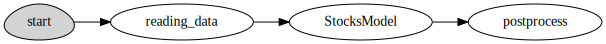

In [2]:
fn = mlrun.code_to_function('serving_stocks', kind='serving',image='mlrun/ml-models', filename='src/serving_stocks.py').apply(mlrun.auto_mount())

graph = fn.set_topology("flow", engine="async")
# Build the serving graph:
graph.to(handler='preprocess', name='reading_data')\
     .to(class_name="StocksModel", model_name='stocks_model', model_path=project.get_artifact_uri('stocks_model'))\
     .to(handler='postprocess',name='postprocess').respond()

fn.set_tracking()

fn.plot(rankdir="LR")

## Testing locally

In [3]:
server = fn.to_mock_server()

> 2022-09-19 08:45:50,063 [info] downloading v3io:///projects/stocks-dani/artifacts/train-stocks-model-handler/0/stocks_model_custom_objects_map.json.json to local temp file
> 2022-09-19 08:45:50,071 [info] downloading v3io:///projects/stocks-dani/artifacts/train-stocks-model-handler/0/stocks_model_custom_objects.zip.zip to local temp file
> 2022-09-19 08:45:58,216 [info] model StocksModel was loaded


In [4]:
import pandas as pd
response = server.test(body={"vector_name": 'stocks',
                             "start_time" : 59,
                             "end_time"   : 0,
                             "seq_size"   : 5})

pd.DataFrame(data=response[0], columns=response[1]).head()

,prediction,datetime,tickers,key,true
0,129.081502,2022-09-16 16:00:00,A,A 2022-09-16 16:00:00,129.890001
1,155.147402,2022-09-16 16:00:00,AAPL,AAPL 2022-09-16 16:00:00,150.699997
2,14.317588,2022-09-16 16:00:00,AAL,AAL 2022-09-16 16:00:00,13.750006
3,144.004556,2022-09-16 16:00:00,ABBV,ABBV 2022-09-16 16:00:00,144.059998
4,140.178250,2022-09-16 16:00:00,ABC,ABC 2022-09-16 16:00:00,140.550004


## Deploying the serving graph

In [5]:
address = fn.deploy()

> 2022-09-19 08:46:00,901 [info] Starting remote function deploy
2022-09-19 08:46:11  (info) Deploying function
2022-09-19 08:46:11  (info) Building
2022-09-19 08:46:11  (info) Staging files and preparing base images
2022-09-19 08:46:11  (info) Building processor image
2022-09-19 08:48:47  (info) Build complete
2022-09-19 08:49:13  (info) Function deploy complete
> 2022-09-19 08:49:14,443 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-dani-serving-stocks.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-dani-serving-stocks-stocks-dani.default-tenant.app.vmdev93.lab.iguazeng.com/']}


We use the set_function on the project instance again to save the function's endpoint

In [6]:
project.set_function(fn,name='serving_stocks')
project.save()

In [7]:
import json
response = fn.invoke(path=address,
                     body={"vector_name": 'stocks',
                           "start_time" : 59,
                           "end_time"   : 0,
                           "seq_size"   : 5})

pd.DataFrame(data=response[0], columns=response[1])

> 2022-09-19 08:49:14,772 [info] invoking function: {'method': 'POST', 'path': 'http://stocks-dani-serving-stocks-stocks-dani.default-tenant.app.vmdev93.lab.iguazeng.com/'}


,prediction,datetime,tickers,key,true
0,129.081502,2022-09-16 16:00:00,A,A 2022-09-16 16:00:00,129.890001
1,155.147402,2022-09-16 16:00:00,AAPL,AAPL 2022-09-16 16:00:00,150.699997
2,14.317576,2022-09-16 16:00:00,AAL,AAL 2022-09-16 16:00:00,13.750006
3,144.004556,2022-09-16 16:00:00,ABBV,ABBV 2022-09-16 16:00:00,144.059998
4,140.178256,2022-09-16 16:00:00,ABC,ABC 2022-09-16 16:00:00,140.550004
5,260.048822,2022-09-16 16:00:00,ABMD,ABMD 2022-09-16 16:00:00,258.670010
6,298.152342,2022-09-16 16:00:00,ADBE,ADBE 2022-09-16 16:00:00,299.500004
7,104.743675,2022-09-16 16:00:00,ABT,ABT 2022-09-16 16:00:00,103.999997
8,268.202074,2022-09-16 16:00:00,ACN,ACN 2022-09-16 16:00:00,272.679993
9,161.255819,2022-09-16 16:00:00,AAP,AAP 2022-09-16 16:00:00,166.800004


## Scheduling the serving function

In [8]:
body = {"vector_name": 'stocks',
        "start_time" : 59,
        "end_time"   : 0,
        "seq_size"   : 5}

# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='prediction_kv',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':address, 'body': body}, schedule='*/10 * * * *')

> 2022-09-19 08:49:17,416 [info] starting run prediction-kv-ingestion_service_invoker uid=f9a413179c0b4610a03395976df245d6 DB=http://mlrun-api:8080
> 2022-09-19 08:49:17,911 [info] task scheduled, {'schedule': '*/10 * * * *', 'project': 'stocks-dani', 'name': 'prediction-kv-ingestion_service_invoker'}
